In [149]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from time import perf_counter

### implementation of basic ae

In [179]:
class Evolutionary_Algorithm:
    __slots__ = [
        "mutation_rate",
        "crossover_rate",
        "number_of_generations",
        "population_size",
        "function_to_optimize",
        "population",
        "problem_dim",
        "hall_of_fame",
    ]

    def __init__(
        self,
        mutation_rate=0.7,
        crossover_rate=0.7,
        number_of_generations=50,
        population_size=100,
    ):
        self.population_size = population_size
        self.number_of_generations = number_of_generations
        self.mutation_rate = mutation_rate
        self.crossover_rate = crossover_rate
        self.function_to_optimize = None
        self.population = None
        self.problem_dim = None
        self.hall_of_fame = []

    def _generate_population(self, n_genes):
        self.population = np.random.uniform(-10, 10, (self.population_size, n_genes))

    def _mutation(self, individual):
        for i in range(len(individual)):
            if np.random.rand() < self.mutation_rate:
                individual += np.random.normal(0, 1, self.problem_dim)
        return individual

    def _crossover(self, parent1, parent2):
        if np.random.rand() < self.crossover_rate:
            crossover_point = np.random.randint(1, self.problem_dim - 1)
            child1 = np.concatenate(
                (parent1[:crossover_point], parent2[crossover_point:])
            )
            child2 = np.concatenate(
                (parent2[:crossover_point], parent1[crossover_point:])
            )
            return child1, child2
        return parent1, parent2

    def _evaluate_population(self):
        fitness = np.zeros(len(self.population))
        for i, individual in enumerate(self.population):
            fitness[i] = self.function_to_optimize(*individual)
        self.hall_of_fame.append(np.argsort(fitness)[: int(self.population_size * 0.1)])
        return fitness

    def _tournament_selection(self, fitness):
        fitness = 1 / fitness
        probabilities = fitness / np.sum(fitness)
        return self.population[
            np.random.choice(
                range(len(self.population)),
                p=probabilities,
                size=self.population_size - len(self.hall_of_fame[-1]),
                replace=True,
            )
        ]

    def _select_individual(self, n=1):
        return self.population[
            np.random.choice(range(self.population_size), size=n, replace=False)
        ]

    def _visualize_individual(self, individual):
        print(individual)

    def optimize(self, function_to_optimize, silent=False):
        # initialize the population
        self.function_to_optimize = function_to_optimize
        self.problem_dim = function_to_optimize.__code__.co_argcount
        self._generate_population(self.problem_dim)
        best_evaluation_in_iteration = []

        # main algorithm loop
        for generation in range(self.number_of_generations):

            # crossover
            children = np.zeros(
                (2 * len(range(0, self.population_size, 2)), self.problem_dim)
            )
            for i in range(0, self.population_size, 2):
                parent1, parent2 = self._select_individual(n=2)
                children[i], children[i + 1] = self._crossover(parent1, parent2)
            self.population = np.vstack([self.population, children])

            # mutation
            mutated = np.zeros((self.population_size, self.problem_dim))
            for i in range(self.population_size):
                individual = self._select_individual()
                mutated[i] = self._mutation(individual)
            self.population = np.vstack([self.population, mutated])

            # evaluate the population and select the best individuals
            fitness = self._evaluate_population()
            if not silent:
                print(
                    f"iter: {generation}, best: {np.min(fitness)} for {['%.3f' % n for n in self.population[self.hall_of_fame[-1][0]]]}"
                )
            self.population = np.vstack(
                [
                    self.population[self.hall_of_fame[-1]],
                    self._tournament_selection(fitness),
                ]
            )

            best_evaluation_in_iteration.append(np.min(fitness))

        return best_evaluation_in_iteration

### definition of objective functions 

In [131]:
def rastrigin_5d(x, y, z, w, v):

    # this implementation takes 57s to run ae with 100 individuals for 200 generations
    # np.array([x, y, z, w, v])
    # return (
    #     10 * 5
    #     + np.sum(np.array([x, y, z, w, v]) ** 2)
    #     - 10 * np.sum(np.cos(2 * np.pi * np.array([x, y, z, w, v])))
    # )

    # this implementation takes only 30 to run ae with 100 individuals for 200 generations almost twice as fast
    return (
        10 * 5
        + x**2
        + y**2
        + z**2
        + w**2
        + v**2
        - 10
        * (
            np.cos(2 * np.pi * x)
            + np.cos(2 * np.pi * y)
            + np.cos(2 * np.pi * z)
            + np.cos(2 * np.pi * w)
            + np.cos(2 * np.pi * v)
        )
    )


def quadratic_3d(x, y, z):
    return x**2 + y**2 + 2 * z**2

In [192]:
ea = Evolutionary_Algorithm(number_of_generations=200, population_size=20)
opt = ea.optimize(quadratic_3d)

iter: 0, best: 11.854610527501665 for ['1.126', '-1.998', '1.816']
iter: 1, best: 8.215381118779764 for ['1.572', '-0.847', '1.585']
iter: 2, best: 5.773827092573574 for ['0.487', '-0.845', '-1.553']
iter: 3, best: 5.773827092573574 for ['0.487', '-0.845', '-1.553']
iter: 4, best: 1.433348164740479 for ['-0.691', '0.302', '0.657']
iter: 5, best: 0.5674759406481048 for ['-0.576', '0.447', '0.133']
iter: 6, best: 0.36101938678760637 for ['0.355', '0.447', '0.133']
iter: 7, best: 0.08562750226578905 for ['-0.207', '0.197', '0.044']
iter: 8, best: 0.08562750226578905 for ['-0.207', '0.197', '0.044']
iter: 9, best: 0.08562750226578905 for ['-0.207', '0.197', '0.044']
iter: 10, best: 0.020670320559003683 for ['-0.072', '-0.086', '0.064']
iter: 11, best: 0.020670320559003683 for ['-0.072', '-0.086', '0.064']
iter: 12, best: 0.020670320559003683 for ['-0.072', '-0.086', '0.064']
iter: 13, best: 0.020670320559003683 for ['-0.072', '-0.086', '0.064']
iter: 14, best: 0.020670320559003683 for ['-0

Text(0, 0.5, 'Best solution value')

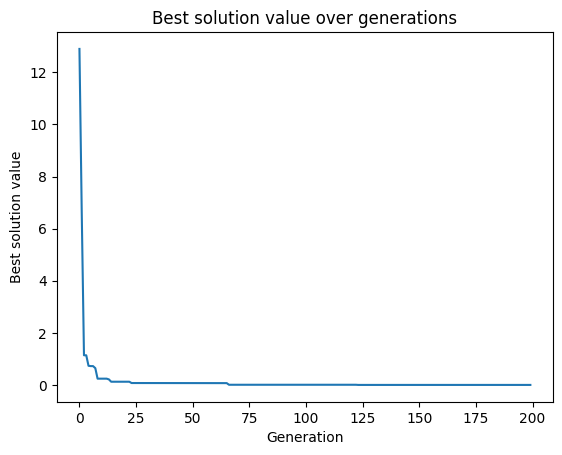

In [190]:
plt.plot(opt)
plt.title("Best solution value over generations")
plt.xlabel("Generation")
plt.ylabel("Best solution value")

In [185]:
ea = Evolutionary_Algorithm(number_of_generations=400, population_size=400)
best_sol = ea.optimize(rastrigin_5d)

iter: 0, best: 25.403953333775007 for ['0.038', '0.970', '1.107', '2.882', '-3.044']
iter: 1, best: 25.403953333775007 for ['0.038', '0.970', '1.107', '2.882', '-3.044']
iter: 2, best: 25.403953333775007 for ['0.038', '0.970', '1.107', '2.882', '-3.044']
iter: 3, best: 9.029408883355245 for ['0.038', '0.970', '0.032', '-2.094', '-0.951']
iter: 4, best: 9.029408883355245 for ['0.038', '0.970', '0.032', '-2.094', '-0.951']
iter: 5, best: 9.029408883355245 for ['0.038', '0.970', '0.032', '-2.094', '-0.951']
iter: 6, best: 9.029408883355245 for ['0.038', '0.970', '0.032', '-2.094', '-0.951']
iter: 7, best: 8.90209109439457 for ['2.011', '0.998', '-1.046', '1.002', '1.036']
iter: 8, best: 5.113446312583626 for ['0.038', '0.998', '-1.046', '1.002', '1.036']
iter: 9, best: 3.923064124829793 for ['0.038', '0.970', '0.032', '1.002', '1.036']
iter: 10, best: 3.8642680914853003 for ['1.013', '0.037', '0.032', '1.002', '1.036']
iter: 11, best: 3.71215512800692 for ['0.018', '0.970', '0.032', '1.00

Text(0, 0.5, 'Best solution value')

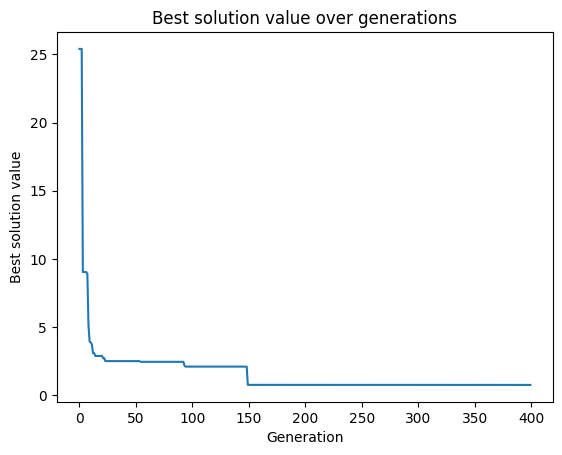

In [186]:
plt.plot(best_sol)
plt.title("Best solution value over generations")
plt.xlabel("Generation")
plt.ylabel("Best solution value")